In [70]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import tensorflow_hub as hub

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 31.53 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls /kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
dataset_dir='/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
import os
filenames = [dataset_dir + filename for filename in os.listdir(dataset_dir)]
filenames

dev.txt  test.txt  train.txt


['/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/kaggle/working/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [4]:
def get_lines(filename):
  with open(filename, "r") as file:
    return file.readlines()

In [8]:
def preprocess_text(filename):
    text_lines=get_lines(filename)
    all_abstracts=[]
    individual_abstract=""
    for line in text_lines:
        if line.startswith('###'):
            individual_abstract=""
        elif line.isspace():
            abstract_line_list=individual_abstract.splitlines()
            for i , single_line in enumerate(abstract_line_list):
                line_dict={}
                target_and_text=single_line.split('\t')
                line_dict['target']=target_and_text[0]
                line_dict['text']=target_and_text[1].lower()
                line_dict['line_number']=i
                line_dict['total_lines']=len(abstract_line_list)-1
                all_abstracts.append(line_dict)
        else:
            individual_abstract+= line
    return all_abstracts
            

In [10]:
%%time
train_samples=preprocess_text(filenames[1])
val_samples=preprocess_text(filenames[0])
test_samples=preprocess_text(filenames[2])

CPU times: user 674 ms, sys: 96.1 ms, total: 770 ms
Wall time: 772 ms


In [12]:
len(train_samples) , len(val_samples) , len(test_samples)

(180040, 30212, 30135)

In [15]:
train_data=pd.DataFrame(train_samples)
val_data=pd.DataFrame(val_samples)
test_data=pd.DataFrame(test_samples)
train_data.head()

train_sentences=train_data['text'].tolist()
val_sentences=val_data['text'].tolist()
test_sentences=test_data['text'].tolist()

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
one_hot_encoder=OneHotEncoder(sparse=False)
label_encoder = LabelEncoder()

train_labels_one_hot = one_hot_encoder.fit_transform(train_data["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_data["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_data["target"].to_numpy().reshape(-1, 1))
train_labels_encoded = label_encoder.fit_transform(train_data["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_data["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_data["target"].to_numpy())

train_labels_one_hot , train_labels_encoded

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([3, 2, 2, ..., 4, 1, 1]))

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

In [30]:
from helper_functions import calculate_results

In [31]:
y_pred=model_0.predict(val_sentences)
calculate_results(val_labels_encoded ,y_pred )

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [35]:
max_tokens=68000
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)
text_vectorizer.adapt(train_sentences)

In [36]:
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [39]:
token_embedding_layer = layers.Embedding(input_dim=text_vectorizer.vocabulary_size(), 
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding") 

In [40]:
token_embedding_layer(text_vectorizer([train_sentences[0]]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.04928315, -0.04273329,  0.03947074, ..., -0.0357628 ,
          0.04576709,  0.01114761],
        [ 0.02096683,  0.03785738,  0.03287668, ...,  0.04053653,
          0.02295775, -0.03173129],
        [-0.03965516, -0.01378386, -0.02736655, ...,  0.04445577,
         -0.00594262, -0.02464507],
        ...,
        [-0.04724375, -0.00743139,  0.03230483, ..., -0.04541121,
         -0.01224339,  0.04691282],
        [-0.04724375, -0.00743139,  0.03230483, ..., -0.04541121,
         -0.01224339,  0.04691282],
        [-0.04724375, -0.00743139,  0.03230483, ..., -0.04541121,
         -0.01224339,  0.04691282]]], dtype=float32)>

In [63]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [42]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [68]:
input_layer=layers.Input(shape=(1,),dtype=tf.string)
text_vector=text_vectorizer(input_layer)
text_embedded=token_embedding_layer(text_vector)
x=layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(text_embedded)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_1 = tf.keras.Model(input_layer, outputs)
model_1.compile(loss="categorical_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])

In [66]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_3 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_3   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 5)                 325 

In [69]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=6,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))) 

Epoch 1/6
562/562 [==============================] - 29s 49ms/step - loss: 0.5339 - accuracy: 0.8225 - val_loss: 0.6325 - val_accuracy: 0.7803
Epoch 2/6
562/562 [==============================] - 7s 12ms/step - loss: 0.4932 - accuracy: 0.8285 - val_loss: 0.6159 - val_accuracy: 0.7776
Epoch 3/6
562/562 [==============================] - 5s 9ms/step - loss: 0.4842 - accuracy: 0.8301 - val_loss: 0.6032 - val_accuracy: 0.7819
Epoch 4/6
562/562 [==============================] - 4s 7ms/step - loss: 0.5889 - accuracy: 0.7900 - val_loss: 0.5841 - val_accuracy: 0.7872
Epoch 5/6
562/562 [==============================] - 6s 11ms/step - loss: 0.5909 - accuracy: 0.7920 - val_loss: 0.5653 - val_accuracy: 0.7985
Epoch 6/6
562/562 [==============================] - 6s 10ms/step - loss: 0.5782 - accuracy: 0.7903 - val_loss: 0.5633 - val_accuracy: 0.8012


In [72]:
tf_hub_use_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [73]:
def split_chars(text):
  return " ".join(list(text))

In [75]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [78]:
max_tokens=68+2
char_vectorizer = TextVectorization(max_tokens=max_tokens,  
                                    output_sequence_length=290,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
char_vectorizer.adapt(train_chars)

In [85]:
char_embedding_layer=layers.Embedding(input_dim=max_tokens,
                                     output_dim=25,
                                     mask_zero=False,
                                     name='char_embedding_layer')


In [86]:
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embedding_layer(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

model_2.compile(loss="categorical_crossentropy",
                optimizer='adam',
                metrics=["accuracy"])

In [87]:
model_2.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding_layer (Embed  (None, 290, 25)          1750      
 ding)                                                           
                                                                 
 conv1d_6 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                     

In [88]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [91]:
model_2_history = model_2.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=4,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/4
562/562 [==============================] - 4s 7ms/step - loss: 0.8059 - accuracy: 0.6916 - val_loss: 0.7689 - val_accuracy: 0.7081
Epoch 2/4
562/562 [==============================] - 4s 6ms/step - loss: 0.7893 - accuracy: 0.6955 - val_loss: 0.7680 - val_accuracy: 0.6985
Epoch 3/4
562/562 [==============================] - 3s 6ms/step - loss: 0.7789 - accuracy: 0.7011 - val_loss: 0.7481 - val_accuracy: 0.7084
Epoch 4/4
562/562 [==============================] - 4s 7ms/step - loss: 0.7597 - accuracy: 0.7100 - val_loss: 0.7420 - val_accuracy: 0.7114


In [94]:
token_input=layers.Input(shape=[],dtype=tf.string, name='token_input')
token_embedded=tf_hub_use_embedding_layer(token_input)
token_dense=layers.Dense(128,activation='relu')(token_embedded)
token_model=tf.keras.Model(token_input, token_dense)

char_input=layers.Input(shape=(1,), dtype=tf.string)
char_vector=char_vectorizer(char_input)
char_embedded=char_embedding_layer(char_vector)
char_BiLSTM=layers.Bidirectional(layers.LSTM(25))(char_embedded)
char_model=tf.keras.Model(char_input, char_BiLSTM)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])


combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)


model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="char_and_token_embedding_hybrid")

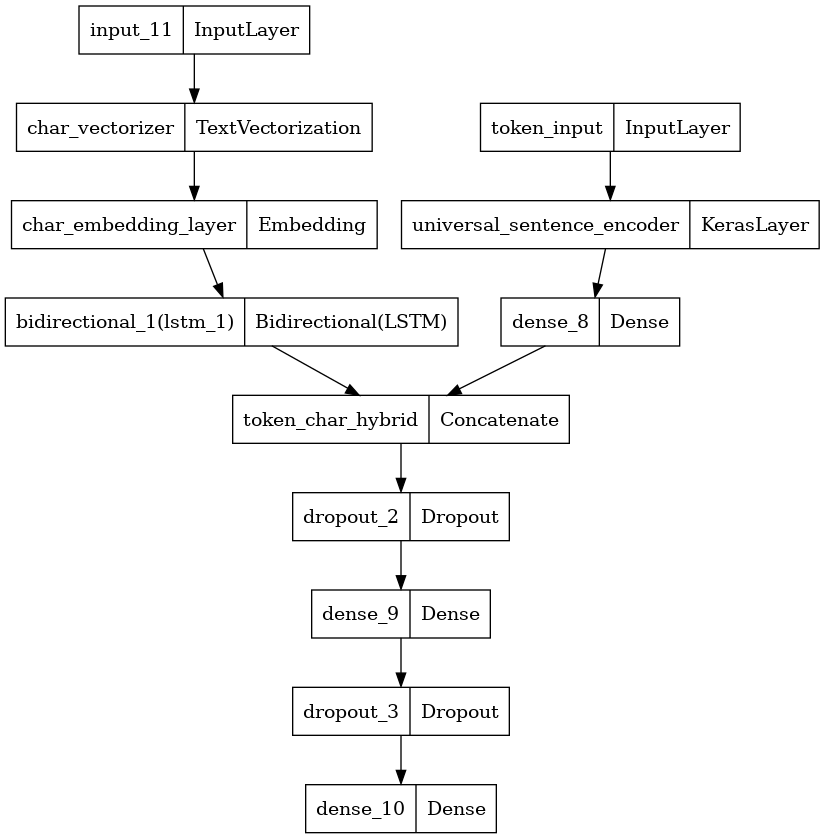

In [96]:
tf.keras.utils.plot_model(model_4)

In [97]:
model_4.summary()

Model: "char_and_token_embedding_hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_11[0][0]']               
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

In [103]:
model_4.compile(optimizer='SGD',loss='categorical_crossentropy',metrics=['accuracy'])

In [100]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [104]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=6,
                              initial_epoch=4,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 5/6
562/562 [==============================] - 28s 42ms/step - loss: 0.6946 - accuracy: 0.7405 - val_loss: 0.6502 - val_accuracy: 0.7553
Epoch 6/6
562/562 [==============================] - 22s 39ms/step - loss: 0.6588 - accuracy: 0.7470 - val_loss: 0.6448 - val_accuracy: 0.7576


In [105]:
train_line_numbers_one_hot = tf.one_hot(train_data["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_data["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_data["line_number"].to_numpy(), depth=15)

In [106]:
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [107]:
train_total_lines_one_hot = tf.one_hot(train_data["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_data["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_data["total_lines"].to_numpy(), depth=20)

In [108]:
token_input=layers.Input(shape=[],dtype=tf.string, name='token_input')
token_embedded=tf_hub_use_embedding_layer(token_input)
token_dense=layers.Dense(128,activation='relu')(token_embedded)
token_model=tf.keras.Model(token_input, token_dense)

char_input=layers.Input(shape=(1,), dtype=tf.string)
char_vector=char_vectorizer(char_input)
char_embedded=char_embedding_layer(char_vector)
char_BiLSTM=layers.Bidirectional(layers.LSTM(25))(char_embedded)
char_model=tf.keras.Model(char_input, char_BiLSTM)

line_number_inp=layers.Input(shape=(15,),dtype=tf.int32)
output_1=layers.Dense(32,activation='relu')(line_number_inp)
line_number_model=tf.keras.Model(line_number_inp, output_1)

total_lines_inp=layers.Input(shape=(20,),dtype=tf.int32)
output_2=layers.Dense(32,activation='relu')(total_lines_inp)
total_lines_model=tf.keras.Model(total_lines_inp, output_2)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])
z=layers.Dense(256,activation='relu')(token_char_concat)
z=layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_lines_model.output,
                                                                z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)

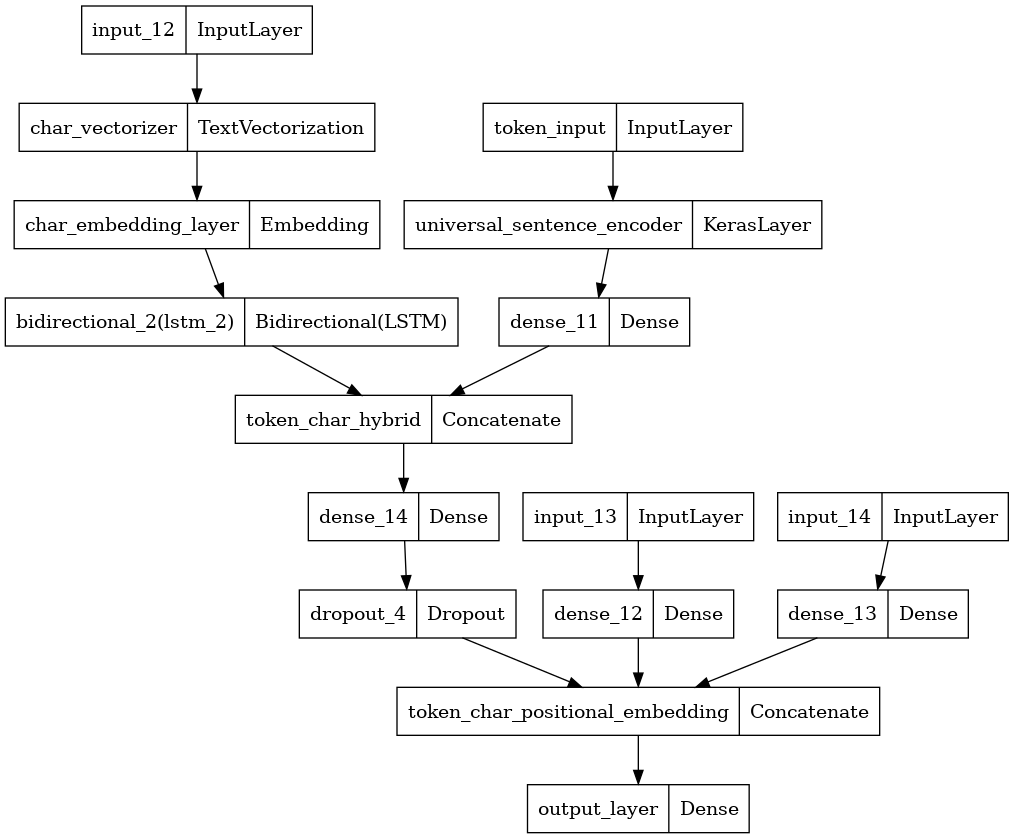

In [109]:
tf.keras.utils.plot_model(model)

In [110]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_12[0][0]']               
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']     

In [111]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='adam',
                metrics=["accuracy"])

In [112]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot, 
                                                                train_sentences, 
                                                                train_chars)) 
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


In [115]:
early_stopper=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
)

In [117]:
history_model_final = model.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.3 * len(train_pos_char_token_dataset)),
                              epochs=25,
                                initial_epoch=16,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)),
                               callbacks=[early_stopper])

Epoch 17/25
1688/1688 [==============================] - 66s 39ms/step - loss: 0.9041 - accuracy: 0.8561 - val_loss: 0.9071 - val_accuracy: 0.8557
Epoch 18/25
1688/1688 [==============================] - 66s 39ms/step - loss: 0.9065 - accuracy: 0.8557 - val_loss: 0.8988 - val_accuracy: 0.8557
Epoch 19/25
1688/1688 [==============================] - 65s 39ms/step - loss: 0.9033 - accuracy: 0.8581 - val_loss: 0.9026 - val_accuracy: 0.8507
Epoch 20/25
1688/1688 [==============================] - 23s 14ms/step - loss: 0.9018 - accuracy: 0.8594 - val_loss: 0.9033 - val_accuracy: 0.8481


In [134]:
model.save(filepath='../kaggle/input/model')

In [140]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        print(files)
        if len(files)!=0:
            for file in files:
                if file_name in file:
                    pass
                else:
                    zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [142]:
zip_dir(directory = '/kaggle/working/model', file_name = 'directory.zip')

['directory.zip', 'saved_model.pb', 'keras_metadata.pb', 'model.zip', 'fingerprint.pb']
[]
['variables.data-00000-of-00001', 'variables.index']


/kaggle/working/model/directory.zip

In [137]:
!pip install directory-downloader 

  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=bd524199dda452aaff030e61ca7be9482d3c0321a0ffe846aa64ec92381d4f42
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4


In [139]:
import asyncio
from directory_downloader import DDownloader


async def main():
    url = "./model"
    downloader = DDownloader()
    await downloader.crawl(url)  # fetch all the links from /directory/
    await downloader.download_files()  # download all files to current directory
    
main()

<coroutine object main at 0x785edf226ab0>

In [150]:
model.save_weights('../model_0.tf')

In [160]:
model_2=tf.keras.models.load_model('../input/model')

In [161]:
model_5_pred_probs = model_2.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 25s 24ms/step


array([[0.5983015 , 0.08947451, 0.02201452, 0.2635485 , 0.02666098],
       [0.6077667 , 0.11358584, 0.03926295, 0.22195427, 0.01743022],
       [0.37059897, 0.08352286, 0.03939854, 0.4594025 , 0.04707717],
       ...,
       [0.02348273, 0.072244  , 0.02575952, 0.02950807, 0.84900564],
       [0.02161089, 0.29256502, 0.02730365, 0.02369747, 0.63482296],
       [0.07134458, 0.8495291 , 0.02458304, 0.02414329, 0.03040003]],
      dtype=float32)

In [162]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 85.34688203362903,
 'precision': 0.8552948389866093,
 'recall': 0.8534688203362902,
 'f1': 0.8506762490421071}